In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
import random

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn.utils   import spectral_norm 



import torch.optim as optim

from tqdm import tqdm
import porespy as ps
from quantimpy import minkowski as mk
from skimage.measure import euler_number
from captum.attr import Occlusion, Saliency

In [2]:
def load_checkpoint(checkpoint_file, model, optimizer, lr):
    """
    Loading training checkpoints
    Parameters
    ----------
    checkpoint_file : :obj:`str`
        Path and file name
    model : :obj:`torch.nn.Module`
        WGAN model
    optimizer : :obj:`torch.optim`
        Optimizer
    lr : :obj:`float`
        Learning rate
    """
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location="cuda")
    model.load_state_dict(checkpoint["state_dict"])
    # optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [3]:
class Generator(torch.nn.Module):
    def __init__(self, in_channel=16, out_channel=128):
        
        super(Generator, self).__init__()
        # channel_in = 16
        # H = 16
        # W = 16
        self.conv_net = torch.nn.Sequential(
            # dim: Bx16x16x16
            torch.nn.ConvTranspose2d(in_channels=in_channel, out_channels=32, kernel_size=4, stride=2, padding=1),
            torch.nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            torch.nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            torch.nn.InstanceNorm2d(32),
            torch.nn.GELU(),
            # dim: Bx32x32x32
            torch.nn.ConvTranspose2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1),
            torch.nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            torch.nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            torch.nn.InstanceNorm2d(64),
            torch.nn.GELU(),
            # dim: Bx64x64x64
            torch.nn.ConvTranspose2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1),
            torch.nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            torch.nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            torch.nn.InstanceNorm2d(128),
            torch.nn.GELU(),
            # dim: Bx128x128x128
            torch.nn.ConvTranspose2d(in_channels=128, out_channels=out_channel, kernel_size=3, stride=1, padding=1),
            torch.nn.ConvTranspose2d(out_channel, out_channel, kernel_size=3, stride=1, padding=1),
            torch.nn.ConvTranspose2d(out_channel, out_channel, kernel_size=3, stride=1, padding=1),
            torch.nn.Sigmoid()
        )
        
    def forward(self, z):
        # z dim: Bx16x16x16
        return self.conv_net(z)

In [4]:
class Discriminator(torch.nn.Module):
    def __init__(self, in_channel=128, out_channel=1):
        
        super(Discriminator, self).__init__()
        # channel_in = 128
        # H = 128
        # W = 128
        self.conv_net = torch.nn.Sequential(
            # dim: Bx128x128x128
            torch.nn.Conv2d(in_channels=in_channel, out_channels=64, kernel_size=4, stride=2, padding=1),
            torch.nn.InstanceNorm2d(64),
            torch.nn.LeakyReLU(0.2),
            # dim: Bx64x64x64
            torch.nn.Conv2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1),
            torch.nn.InstanceNorm2d(32),
            torch.nn.LeakyReLU(0.2),
            # dim: Bx32x32x32
            torch.nn.Conv2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1),
            torch.nn.InstanceNorm2d(16),
            torch.nn.LeakyReLU(0.2),
            # dim: Bx16x16x16
            torch.nn.Conv2d(in_channels=16, out_channels=8, kernel_size=4, stride=2, padding=1),
            torch.nn.InstanceNorm2d(8),
            torch.nn.LeakyReLU(0.2),
            # dim: Bx8x8x8
            torch.nn.Conv2d(in_channels=8, out_channels=4, kernel_size=4, stride=2, padding=1),
            torch.nn.InstanceNorm2d(4),
            torch.nn.LeakyReLU(0.2),
            # dim: Bx4x4x4
            torch.nn.Conv2d(in_channels=4, out_channels=2, kernel_size=4, stride=2, padding=1),
            torch.nn.InstanceNorm2d(2),
            torch.nn.LeakyReLU(0.2),
            # dim: Bx1x1x1
            torch.nn.Conv2d(in_channels=2, out_channels=out_channel, kernel_size=4, stride=2, padding=1),
        )
        
    def forward(self, z):
        # z dim: Bx128x128x128
        return self.conv_net(z)

In [5]:
def porosity(phi):
    r"""
    Computes the porosity of a sample (image, real or generated).
    Here 0 values correspond to the voids, and 1 values correspond to the grains.
    
    Parameters
    ----------
    phi: input array corresponding to the pixels of the image.
    
    
    Returs
    ------
    porosity: float
              Returns the computed porosity, it is equal to the sum of voids (0), over
              the sum of the voids(0) and solids(1)
    """
    voids = torch.sum(torch.round(phi)  == 0, dim=(-2, -1))
    solids = torch.sum(torch.round(phi)  == 1, dim=(-2, -1))
    phi_computed = voids/(voids + solids)
    
    return phi_computed

In [6]:
# Device and Model
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

CHECKPOINT_GEN = ""
CHECKPOINT_CRITIC = ""

# Training hyperparameters
LEARNING_RATE = 1e-3
BATCH_SIZE = 64

Z_DIM = 16

NUM_EPOCHS = 201
CRITIC_ITERATIONS = 4
LAMBDA_GP = 25

In [7]:
# Traditional 2D slices
DATA = torch.load('./data/berea/original/raw/dataset_berea.pt')/255
DATASET = DATA.clone()[:, 0, :, :].unsqueeze(1)
print(DATASET.shape)

torch.Size([729, 1, 128, 128])


In [8]:
# fixed noise for display
fixed_noise = torch.randn(BATCH_SIZE, Z_DIM, Z_DIM, Z_DIM).to(DEVICE)
torch.save(fixed_noise, 'latent_z.pt')

In [9]:
# initialize generator and critic
gen = Generator(in_channel=16, out_channel=1).to(DEVICE)
# initialize_weights(gen)

critic = Discriminator(in_channel=1, out_channel=1).to(DEVICE)
# initialize_weights(critic)


# initialize optimizer
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))

opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))

load_checkpoint('./data/beadpack/original/tiff/generator_399.pt', model=gen, optimizer=opt_gen, lr=1e-3)
load_checkpoint('./data/beadpack/original/tiff/critic_399.pt', model=critic, optimizer=opt_critic, lr=1e-3)

=> Loading checkpoint
=> Loading checkpoint


In [12]:
l_r= 1e-3
m_listD= []

for i in range(24,474,25):
    critic = Discriminator(in_channel=1, out_channel=1).to(DEVICE)
    load_checkpoint('./data/berea/original/raw/v2/critic_{}.pt'.format(i), model=critic, optimizer=opt_critic, lr=l_r)
    m_listD.append(critic)

=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint


In [13]:
l_r= 1e-3
m_listG= []

for i in range(24,474,25):
    gen = Generator(in_channel=16, out_channel=1).to(DEVICE)
    load_checkpoint('./data/berea/original/raw/v2/generator_{}.pt'.format(i), model=gen, optimizer=opt_critic, lr=l_r)
    m_listG.append(gen)

=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint


## Generator XAI

In [14]:
images_real = DATASET
#images_fake = gen(fixed_noise).detach().cpu()
fixed_noise = torch.load('latent_z.pt')
fixed_noise = fixed_noise[0,:,:,:].unsqueeze(0)
# fake_images = gen(fixed_noise).detach().cpu()

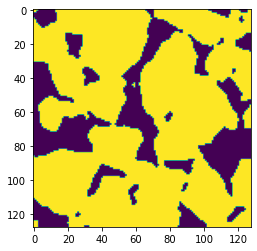

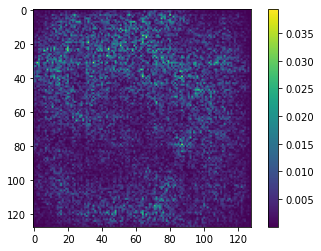

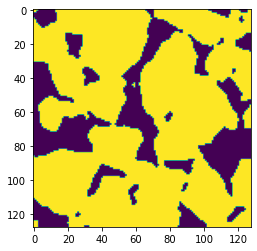

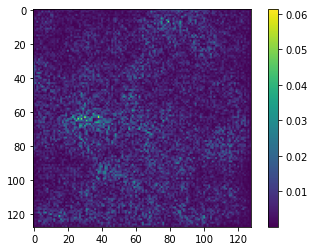

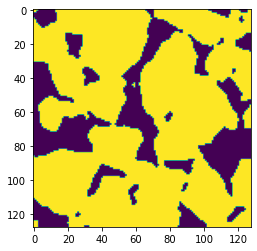

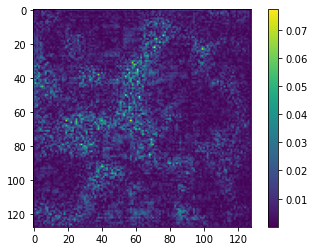

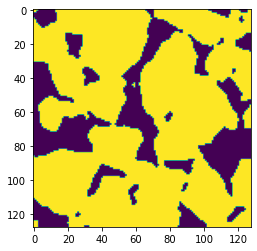

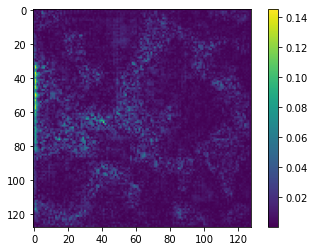

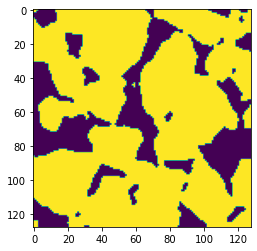

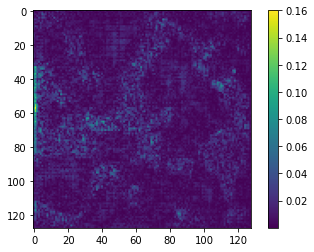

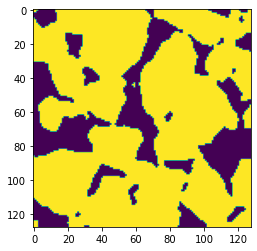

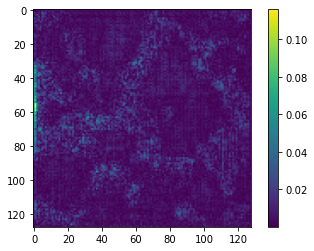

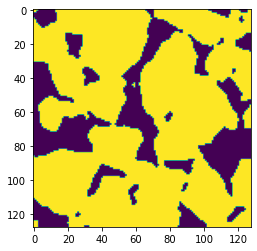

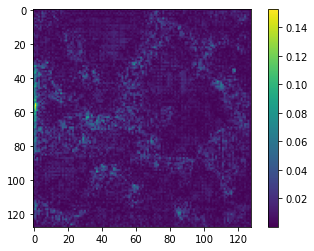

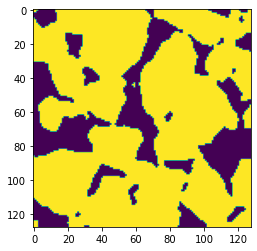

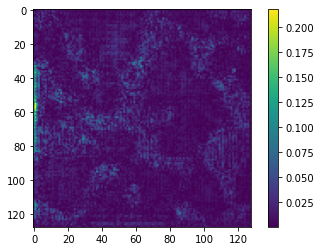

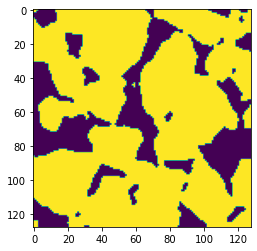

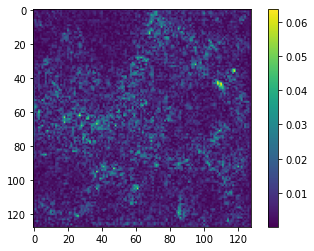

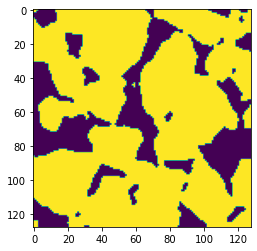

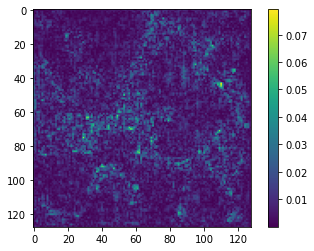

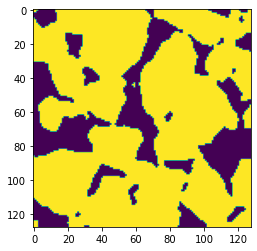

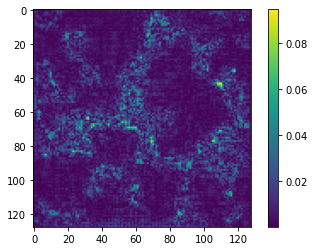

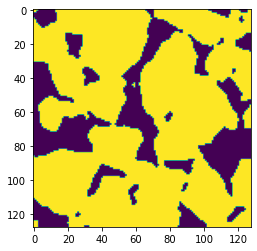

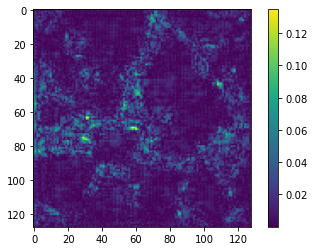

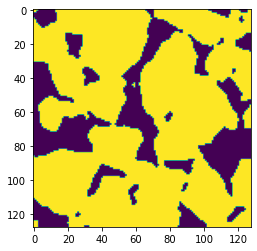

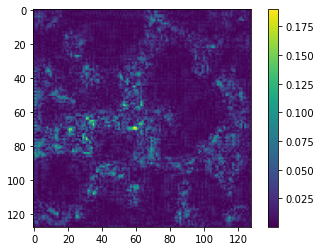

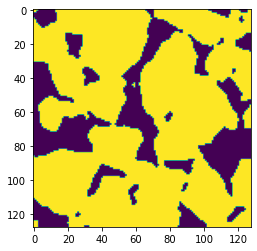

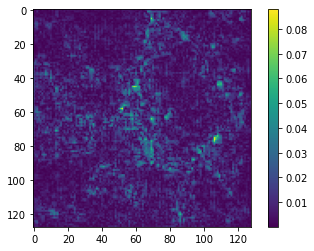

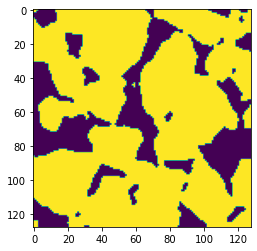

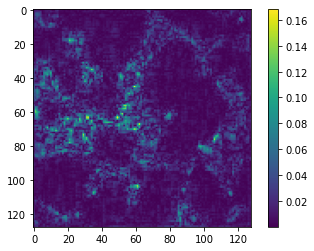

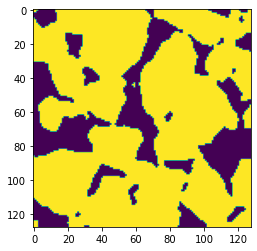

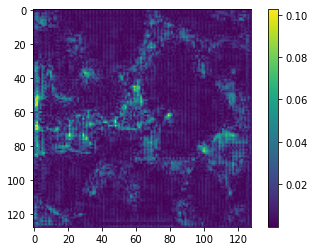

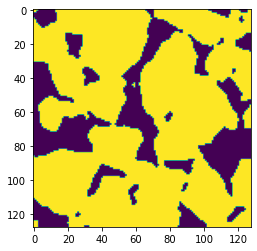

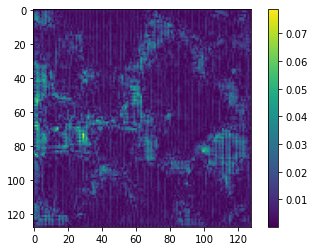

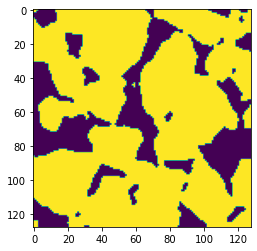

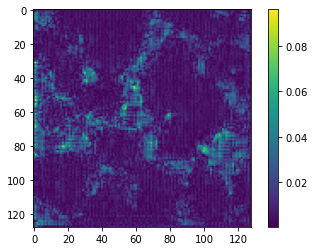

In [20]:
for critic in m_listD:
    ablator = Saliency(critic)
    attr = ablator.attribute(DATASET[0, :, :, :].unsqueeze(1).to(DEVICE)) #, sliding_window_shapes=(1,25,25))
    plt.figure()
    plt.imshow(DATASET[0, 0, :, :])
    plt.show()
    plt.figure()
    plt.imshow(torch.abs(attr[0,0,:,:].detach().cpu()))
    plt.colorbar()
    plt.show()
    

tensor(1.1619e-30)


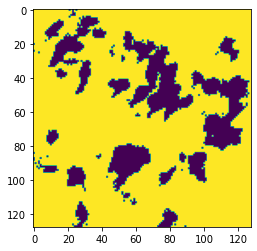

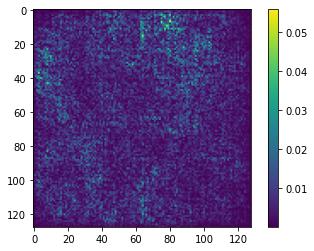

tensor(0.)


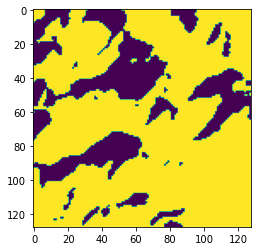

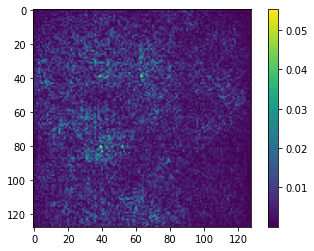

tensor(0.)


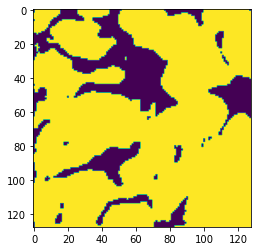

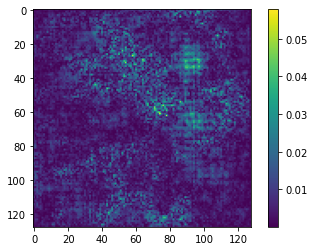

tensor(0.)


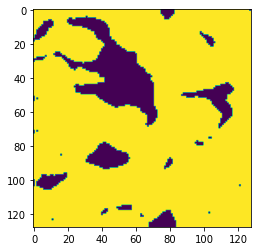

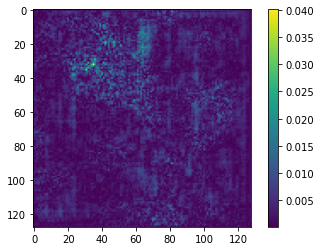

tensor(1.3027e-14)


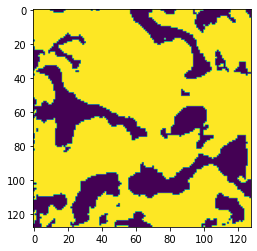

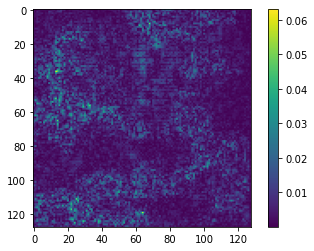

tensor(1.8172e-08)


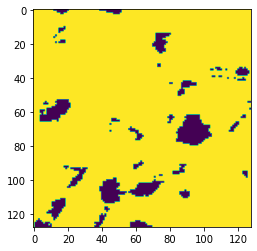

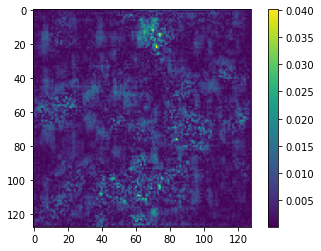

tensor(1.0932e-09)


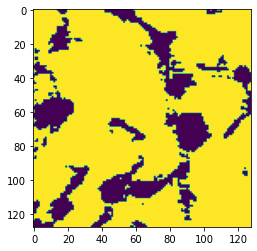

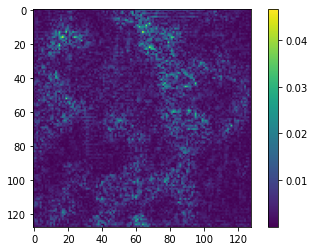

tensor(2.9147e-32)


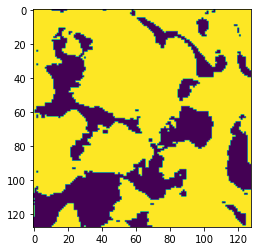

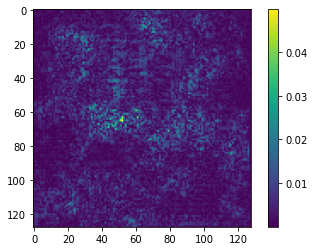

tensor(0.)


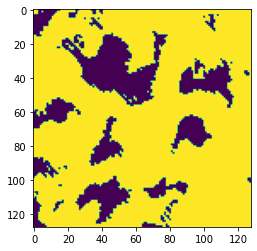

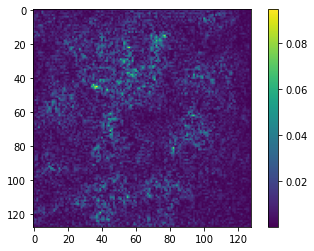

tensor(3.9440e-35)


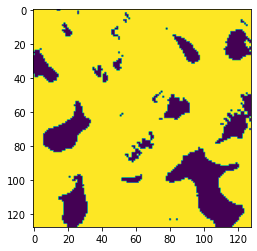

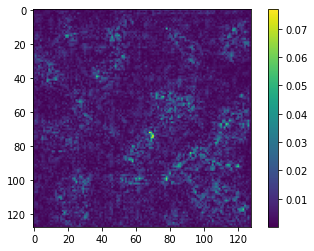

tensor(0.)


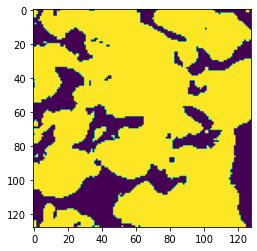

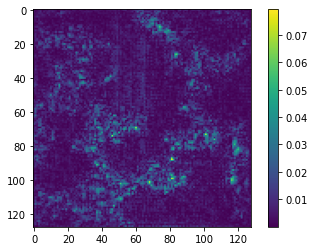

tensor(1.2143e-31)


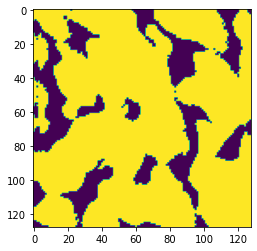

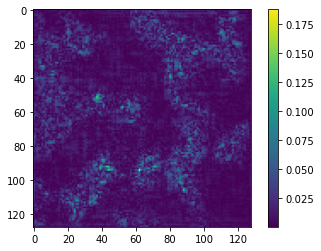

tensor(7.5762e-12)


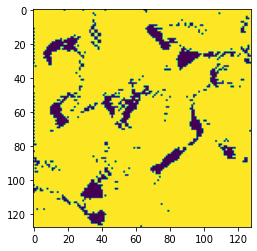

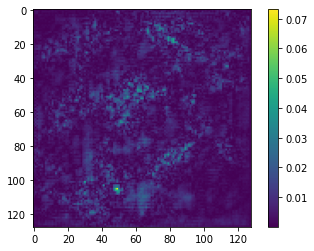

tensor(1.1600e-22)


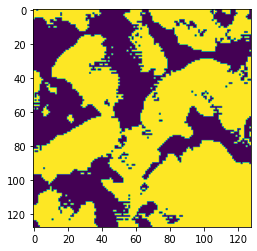

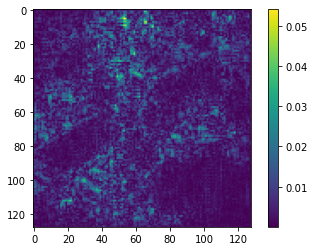

tensor(7.4702e-23)


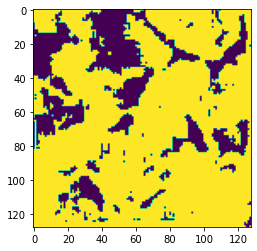

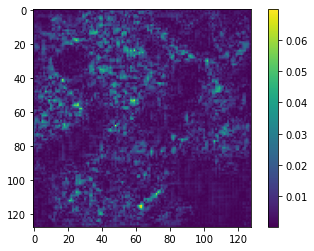

tensor(0.)


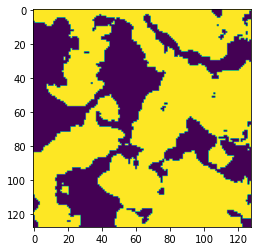

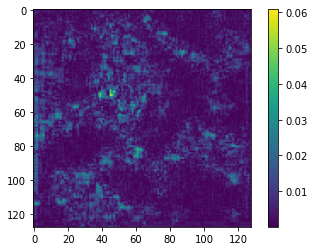

tensor(0.)


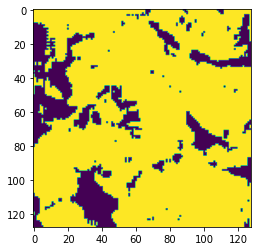

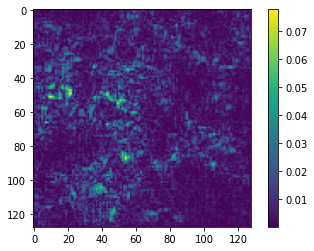

tensor(0.)


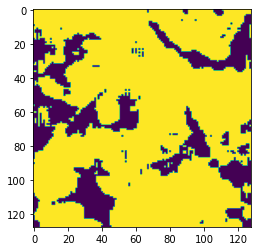

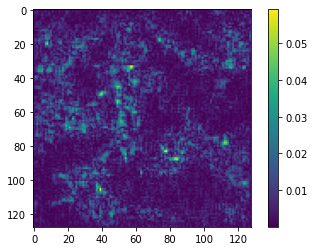

In [21]:
for gen, critic in zip(m_listG, m_listD):
    im = (gen(fixed_noise).detach().cpu())
    
    plt.figure()
    plt.imshow(torch.round(im[0,0,:,:]))
    plt.show()
    
    ablator = Saliency(critic)
    attr = ablator.attribute(im.to(DEVICE)) #, sliding_window_shapes=(1,25,25))
    plt.figure
    plt.imshow(torch.abs(attr[0,0,:,:].detach().cpu()))
    plt.colorbar()
    plt.show()
    

## Oclussion

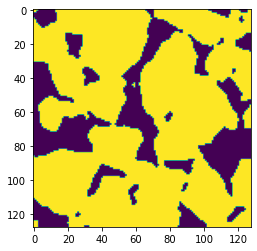

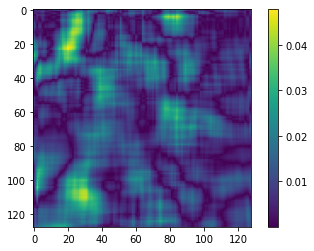

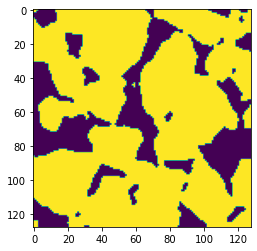

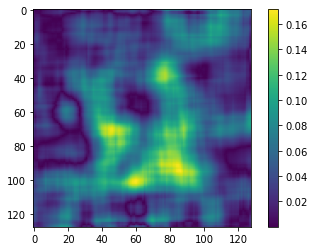

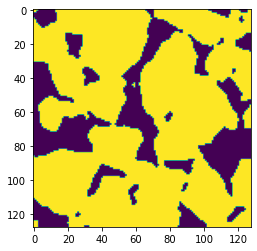

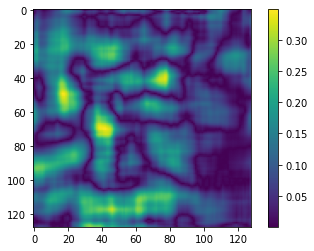

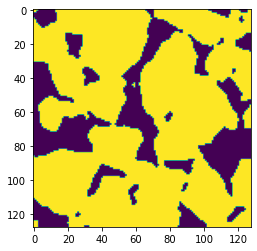

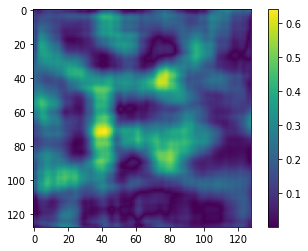

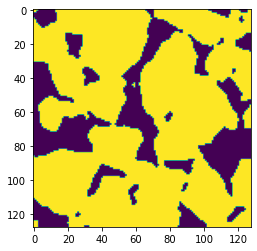

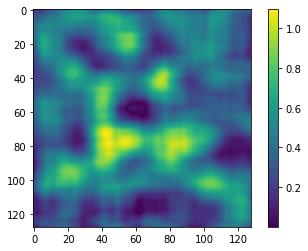

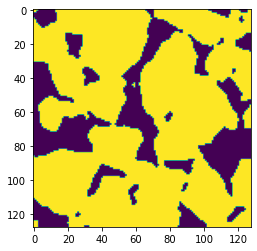

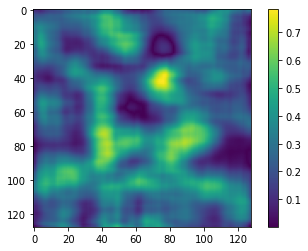

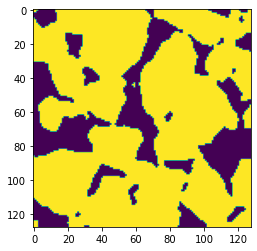

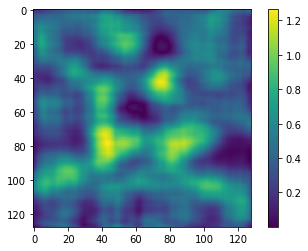

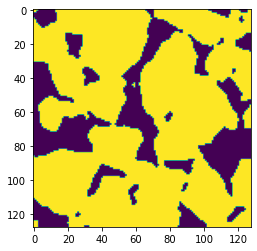

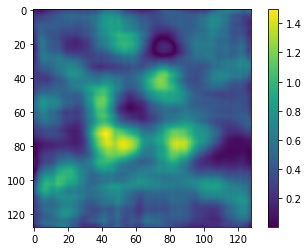

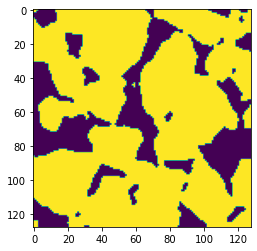

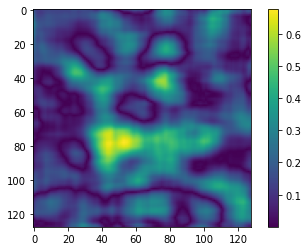

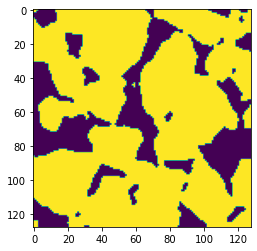

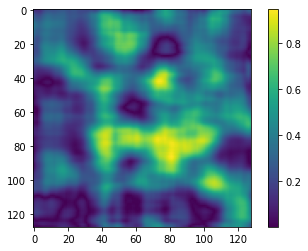

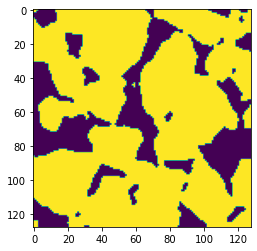

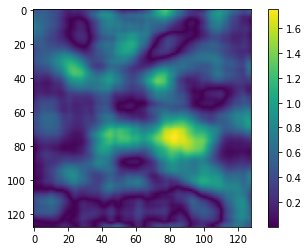

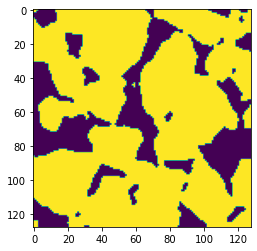

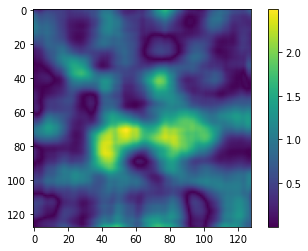

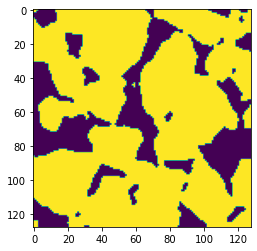

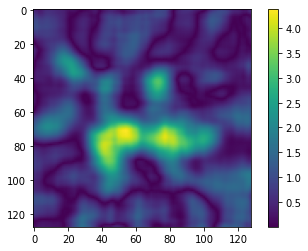

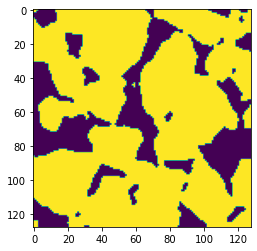

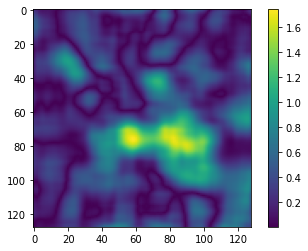

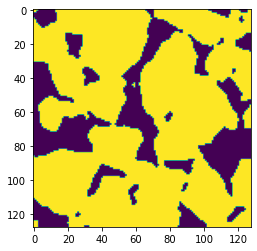

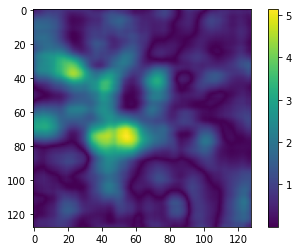

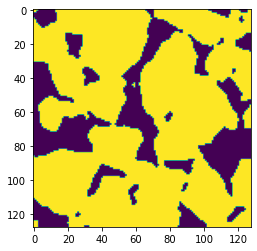

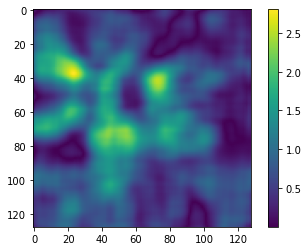

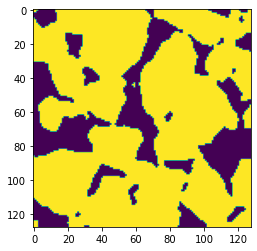

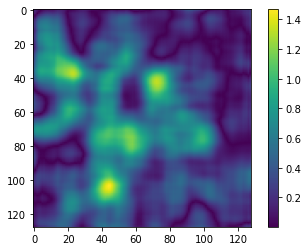

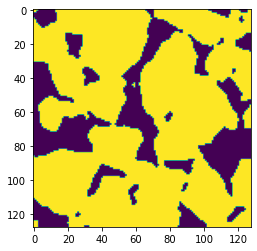

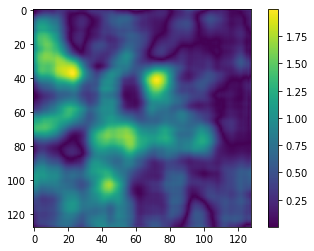

In [22]:
for critic in m_listD:
    ablator = Occlusion(critic)
    attr = ablator.attribute(DATASET[0, :, :, :].unsqueeze(1).to(DEVICE), sliding_window_shapes=(1,13,13))
    plt.figure()
    plt.imshow(DATASET[0, 0, :, :])
    plt.show()
    plt.figure
    plt.imshow(torch.abs(attr[0,0,:,:].detach().cpu()))
    plt.colorbar()
    plt.show()

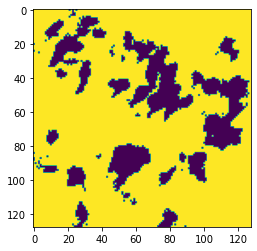

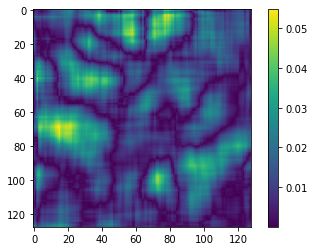

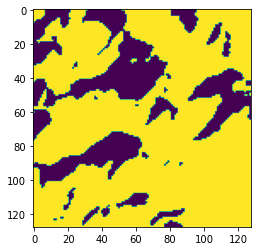

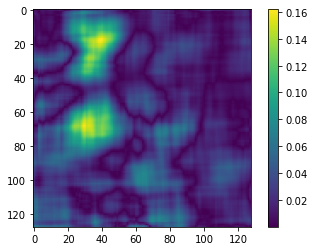

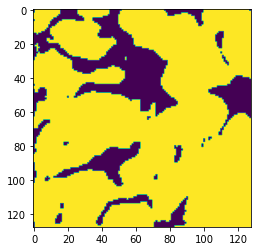

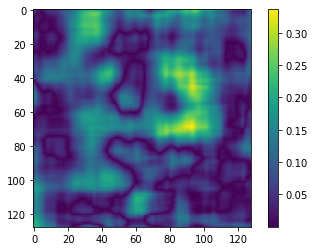

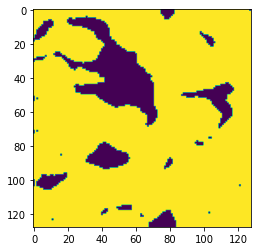

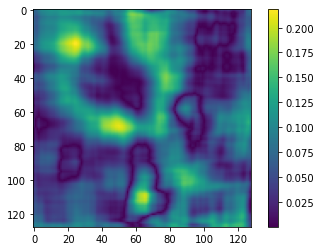

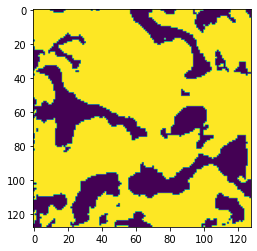

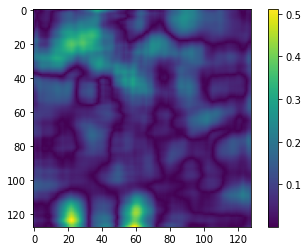

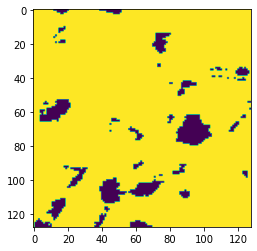

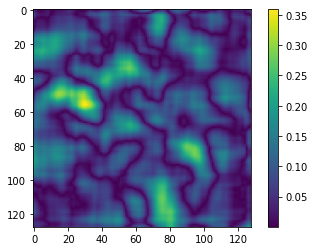

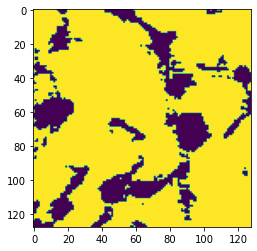

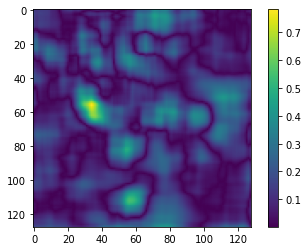

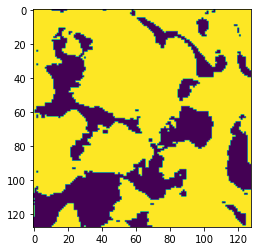

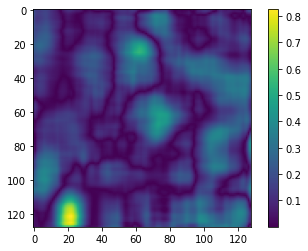

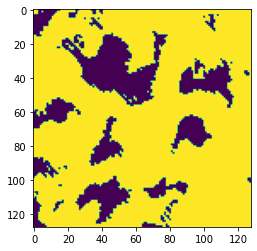

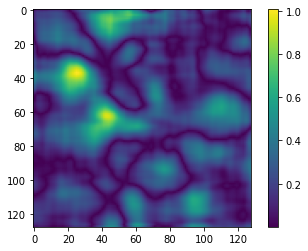

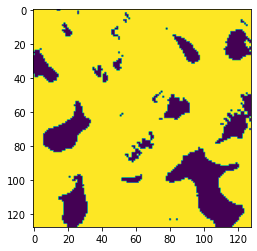

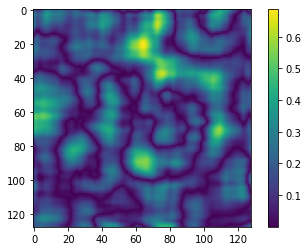

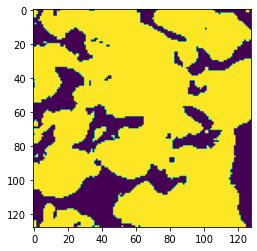

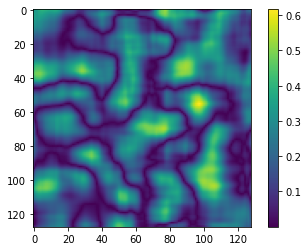

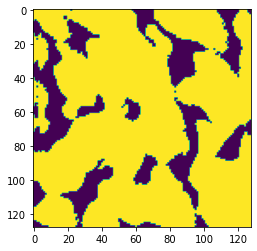

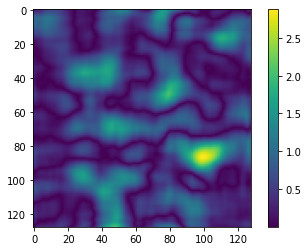

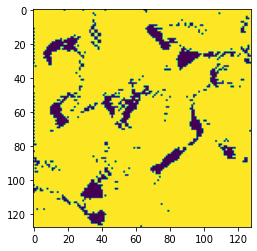

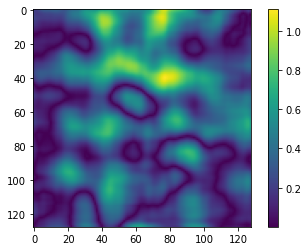

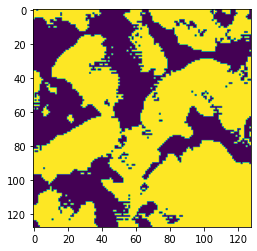

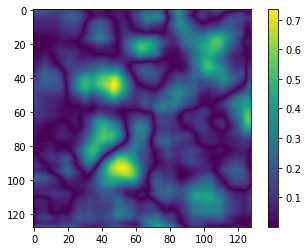

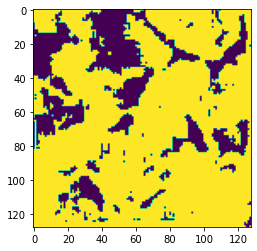

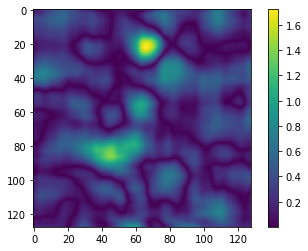

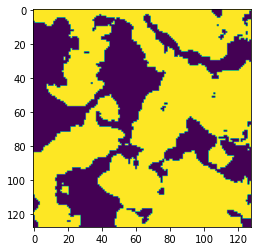

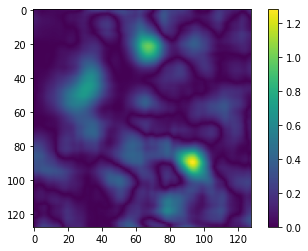

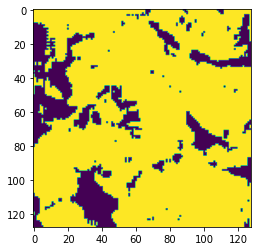

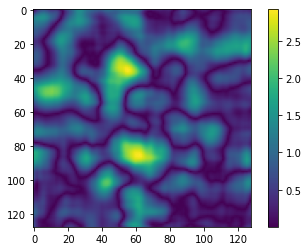

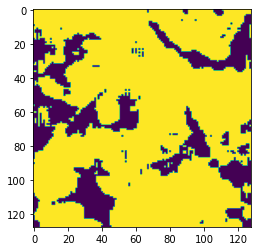

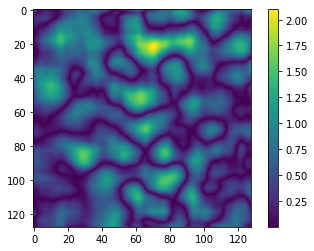

In [23]:
for gen, critic in zip(m_listG, m_listD):
    im = torch.round(gen(fixed_noise).detach().cpu())
    
    plt.figure()
    plt.imshow(torch.round(im[0,0,:,:]))
    plt.show()
    
    ablator = Occlusion(critic)
    attr = ablator.attribute(im.to(DEVICE), sliding_window_shapes=(1,13,13))
    plt.figure
    plt.imshow(torch.abs(attr[0,0,:,:].detach().cpu()))
    plt.colorbar()
    plt.show()

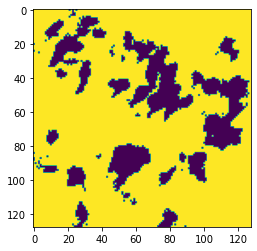

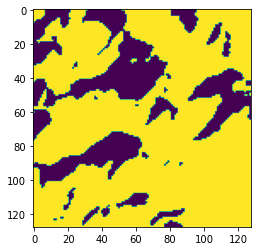

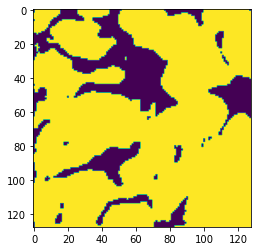

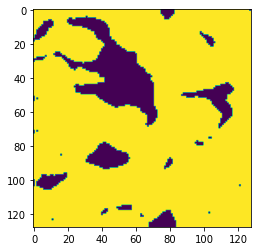

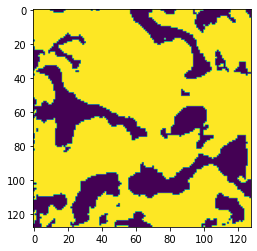

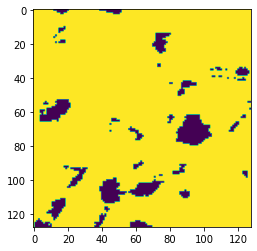

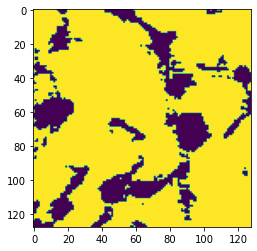

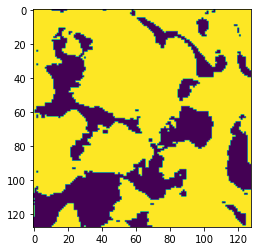

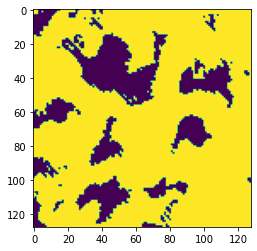

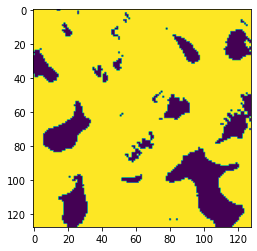

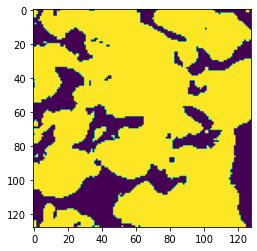

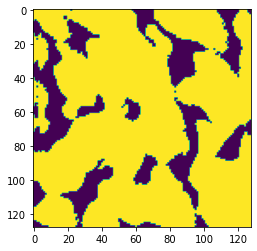

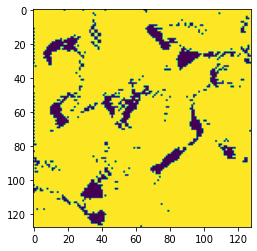

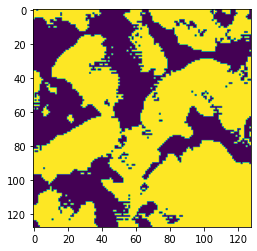

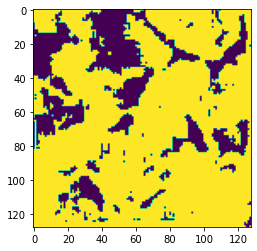

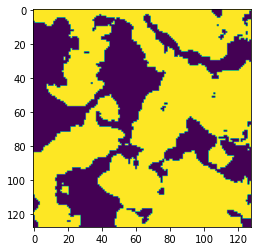

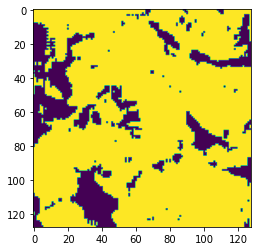

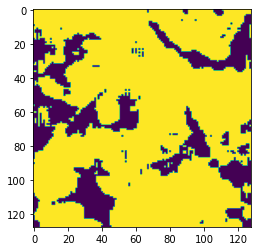

In [24]:
for gen, critic in zip(m_listG, m_listD):
    im = torch.round(gen(fixed_noise).detach().cpu())
    
    plt.figure()
    plt.imshow(torch.round(im[0,0,:,:]))
    plt.show()